# Labeling the news with the dollar variation

Now we ave to label each news with the respective dollar variation

## Importing the libraries and loading the FastText model

In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras

from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors

word_vec_model = KeyedVectors.load_word2vec_format('../datasets/word-vectors/wiki.pt/wiki.pt.vec')

word_vec_model

import matplotlib.pyplot as plt 

Using TensorFlow backend.


## Importing and indexing the dollar dataframe

In [4]:
dolar_rates_df = pd.read_csv('../datasets/pre-processed/dolar_rates.csv')

dolar_rates_df = dolar_rates_df.set_index("quote_timestamp")

dolar_rates_df.tail(5)

variation
quote_timestamp                  
2019-08-29 10:09:17.705        up
2019-08-29 11:10:17.541        up
2019-08-29 12:11:17.181      down
2019-08-29 13:09:45.961      down
2019-08-29 13:09:45.964        up

## Importing and indexing the news dataframe

In [5]:
news_df = pd.read_csv('../datasets/pre-processed/news.csv')
news_df = news_df.set_index("date_published")

news_df.head(5)

text
date_published                                                        
2019-05-28 22:40:00  bolsonaro diz ter mais poder que maia por ter ...
2019-05-28 12:46:00  por corte menor, sistema s promete a bolsonaro...
2019-05-28 11:16:00  major olímpio sobre moro: "não dá para defende...
2019-05-28 02:00:00  doria é stalinista ao dizer que quem não conco...
2019-05-28 10:24:00  planalto, congresso e stf combinam assinar pac...

## Reindexing the dollar dataframe by the nearest news timestamp

In [6]:
dolar_rates_df = dolar_rates_df.reindex(news_df.index, method='backfill')

dolar_rates_df = dolar_rates_df.loc[~dolar_rates_df.index.duplicated(keep='first')]

dolar_rates_df.head(10)

variation
date_published               
2019-05-28 22:40:00      down
2019-05-28 12:46:00        up
2019-05-28 11:16:00      down
2019-05-28 02:00:00        up
2019-05-28 10:24:00      down
2019-05-28 10:59:00      down
2019-05-28 09:15:00        up
2019-05-28 13:17:00      down
2019-05-28 13:46:00      down
2019-05-28 14:41:00      down

## Joining the two dataframes by their indexes

In [7]:
news_df = news_df.join(dolar_rates_df)
news_df = news_df.reset_index()
news_df = news_df.drop(['date_published'], axis=1)
news_df = news_df.dropna(subset=['variation'])

news_df = news_df[news_df.variation != 'steady']

news_df.head(5)

text variation
3  candidato do prtb em sp defende máquina menor....      down
4  distanciamento de alckmin em são paulo esfria ...      down
5  bank of america projeta dólar em r$ 5,50 depoi...      down
6  indústria apresenta proposta de reforma tribut...        up
7  meirelles não pode ter vergonha de temer, afir...        up

# Tokenizing the text

Transforming all the news texts into sequences of numbers

## Extracting the text from the dataframe

In [8]:
news_text = news_df.drop(['variation'], axis = 1).to_numpy()
news_text = np.squeeze(np.asarray(news_text))
news_text

array(['candidato do prtb em sp defende máquina menor. o advogado rodrigo tavares promete cortar pela metade número de cargos comissionados',
       'distanciamento de alckmin em são paulo esfria sua relação com márcio frança. entorno do governador vê com ceticismo chance de vitória de tucano e abre portas para ciro',
       'bank of america projeta dólar em r$ 5,50 depois das eleições. cenário crítico ocorreria caso o novo presidente eleito fosse contra reformas',
       ...,
       'senado aprova redução de ministérios e coaf sem moro após apelo de bolsonaro. casa confirma decisão da câmara e derrota de ministro da justiça; órgão ficará na economia',
       'bolsonaro diz ter mais poder que maia por ter "caneta para editar decretos". durante evento, presidente comentou encontro que teve com chefes do legislativo e do judiciário',
       'veja quais senadores votaram para que o coaf ficasse com moro na justiça. senado aprovou a transferência do órgão para a economia nesta terça (28)']

## Transforming the text into an array of word vector means

In [9]:
means_array = []
for sentence in news_text:
    word_vectors_array = []
    for word in text_to_word_sequence(sentence):
        if word in word_vec_model.vocab:
            word_vectors_array.append(word_vec_model[word])
    mean = np.mean(word_vectors_array, axis=0)
    means_array.append(mean)

means_array


#tokenizer.fit_on_texts(news_text)

#sequences = tokenizer.texts_to_sequences(news_text)

#sequences

[array([ 0.07859025,  0.10778666, -0.1401249 , -0.07348616,  0.15951389,
         0.0964525 ,  0.10891547, -0.00354898,  0.11328585, -0.106179  ,
         0.11239146,  0.10415802,  0.04269367,  0.1264658 ,  0.00400565,
        -0.0467223 ,  0.1268527 , -0.27639592,  0.03072125, -0.14760555,
         0.00967005, -0.22030851, -0.00653833,  0.05612726,  0.1262526 ,
        -0.11269569, -0.08695846, -0.15259595,  0.00857717, -0.03561655,
         0.12722105, -0.1391618 , -0.14149243,  0.02848242, -0.10969315,
        -0.08110018,  0.0959629 , -0.0643248 , -0.09732546, -0.04069755,
         0.03651545,  0.1567308 ,  0.04194934,  0.007919  , -0.06376689,
         0.07895882,  0.10222975,  0.04068065, -0.09229337, -0.19795306,
        -0.17221673,  0.08872174,  0.04489914,  0.0226384 , -0.03410186,
        -0.14505838,  0.0177514 , -0.0653741 , -0.10833277,  0.0004856 ,
         0.0317525 ,  0.02703355, -0.05732527, -0.09810089, -0.06126815,
        -0.0098945 , -0.10433708,  0.00758561,  0.0

# Extracting the labels

In [10]:
news_df['variation'] = news_df['variation'].apply(lambda variation: int(1) if variation == 'up' else int(0))


labels = news_df[['variation']].to_numpy()

labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

# Plotting the classes distribution accross the dataset

(array([2089.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2172.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

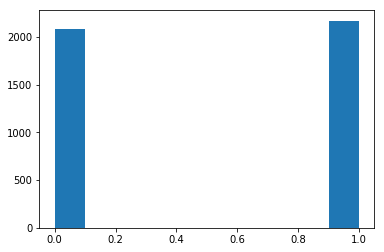

In [11]:
plt.hist(labels)

In [12]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 2089, 1: 2172}

# Saving the final datasets into files

In [13]:
np.savetxt("../datasets/final-data/features.csv", means_array, delimiter=",")
np.savetxt("../datasets/final-data/labels.csv", labels, delimiter=",")